# Table of Contents  

### 1. Introduction and background  

### 2. Methodology in brief

### 3. Detailed methodology and results  
#### &nbsp;&nbsp;&nbsp;&nbsp; 3.1. Data preprocessing  
#### &nbsp;&nbsp;&nbsp;&nbsp; 3.2. ARIMA-model fitting and forecasting  
#### &nbsp;&nbsp;&nbsp;&nbsp; 3.3. GARCH-model fitting and forecasting  

### 4. Performance Evaluation  
#### &nbsp;&nbsp;&nbsp;&nbsp; 4.1. ARIMA-model
#### &nbsp;&nbsp;&nbsp;&nbsp; 4.2. GARCH-model 

### 5. Use of LLMs  

### 6. Conclusion  

### 7. References  

# 1. Introduction and background 
The focus of this project is to research the development of the overall stock market in recent years, specifically the last 5 years. One of the most fundamental indexes representing the overall development in the stock market is the S&P 500 index. Therefore, the price levels of this index will be the research object of our project. The financial market exhibits strong time-series characteristics, including trends, seasonality, and volatility clustering, making it an ideal candidate for time-series modeling. Therefore, time-series models from empirical finance will be used to study historical trends and thereafter predict both price levels and volatility in the future. To predict price levels we will use an Autoregressive Integrated Moving Average model (ARIMA), and to predict volatility we will use a Generalized Autoregressive Conditional Heteroskedasticity model (GARCH).   

# 2. Methodology in brief

To complete this project we plan to use Python with libraries such as "statsmodels" for ARIMA estimation, "arch" for GARCH modeling, "matplotlib" and "seaborn" for data visualization, and "scikit-learn" for performance evaluation.

The price data on the S&P 500 index will be retrieved from XXX and then undergo a preprocessing phase, where raw prices are converted into log returns to stabilize variance. Additionally, the data will be split into a training subset covering 256 weeks, and a test subset covering 4 weeks.

Then we will fit and select an ARIMA model for price level forecasting, by first checking for stationarity through the Dickey-Fuller test and then plotting the autocorrelation function (ACF) and partial autocorrelation function (PACF) to determine optimal model parameters. In a similar manner, we will fit a GARCH(1,1) model for volatility forecasting, using techniques such as XXX. Both models are run on the training data to forecast future prices and volatility for the S&P 500 index. These forecasts are visualized and compared to the actual data in the test set to evaluate the performance of both models. The ARIMA model is evaluated based on its Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) compared to the actual data, whereas the GARCH model performance is evaluated based on log-likelihood, AIC, and out-of-sample volatility forecasts.

Finally, the report will comment on the use of Language Learning Models (LLM) to solve this problem instead of time series models such as ARIMA and GARCH.

# 3. Detailed methodology and results  

### 3.1 Data Preprocessing  
The first phase of our project dealt with preprocessing the S&P 500 data. The daily closing prices of the index over the last 5 years was retrieved from XXX and converted into a csv file. Then the prices were converted into log returns, using the following formula:

$$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$$

where r_t is the log return at time t and P_t is the closing price at time t.

Minor formatting changes were also completed before splitting the data into a test set of 256 weeks and a training set of 4 weeks which were each saved as separate csv files for later use. The details of our data preprocessing can be found in the commented code below.

In [1]:
#Import Relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Load dataset
file_path = "S&P500_L5Y.csv"
df = pd.read_csv(file_path)

#Convert to datetime format and make sure its sorted in ascending order
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.sort_values(by='Date')

#Rename 'Close/Last' column
df.rename(columns={'Close/Last': 'Close'}, inplace=True)

#Convert prices to log returns
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

#Drop first row due to conversion to log returns
df = df.dropna()

#Split data into training and testing subsets
train_size = 256 * 5  # 1280 business days = 256 weeks
test_size = 4 * 5  # 20 business days = 4 weeks
train_data = df.iloc[:-test_size]
test_data = df.iloc[-test_size:]

#Save as csv-files
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

### 3.2 ARIMA-model fitting and forecasting  

We will use an ARIMA model to forecast price levels of the S&P 500. We load the preprocessed training data and index it by date to faciliate for time-series analysis. Then we perform a Dickey-Fuller test to check if the data is stationary. This is important because the ARIMA-model assumes that a time series is stationary, meaning that statistical properties such as mean and varaince should not change over time. If the resulting p-value from the test is greater than 0.05, the data is categorized as non-stationary, meaning that it must be differenced before it can be applied in the ARIMA model. Differencing involves subtracting the previous value from the current value to remove trends and stabilize the mean. On the other hand, if the resulting p-value from the test is below 0.05, the data is already stationary and we can use it directly in the ARIMA model. The code below checks for stationarity and completes differencing if necessary. It then outputs a short description of what is has done.

In [2]:
#Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

#Load preprocessed training data
df = pd.read_csv("train_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

#Test stationarity
adf_test = adfuller(df['Close'])
if adf_test[1] > 0.05:  # If p-value > 0.05, the series is non-stationary
    d = 1
else:
    d = 0

#Print results, applying differencing if necessary
if d == 1:
    df['Close_diff'] = df['Close'].diff().dropna()
    data_to_use = df['Close_diff'].dropna()
    print("The data was non-statiornary. Differencing has been completed")
else:
    data_to_use = df['Close']
    print("The data was already statiornary. No differencing necessary")

The data was non-statiornary. Differencing has been completed


Now that we have ensured stationary data we can plot the ACF and PACF in order to determine optimal model paramters. The ACF measures how much past values influence future values by showing the correlation between our time series and different lagged values. At the lag where the ACF plot dies down, we can determine the moving average component (q) of our process. The PACF is similar, but measures direct correlation to a specific lag, removing the effect of other lags in between. At the lag where the PACF plot dies down, we can determine the autoregressive component (p) of our process. Both plots are outputted by the code below, which first outputs the normal ACF and PACF and then outputs versions that have removed lag 0, since this always has a correlation equal to 1 anyaways, and makes it harder to read the other results. 

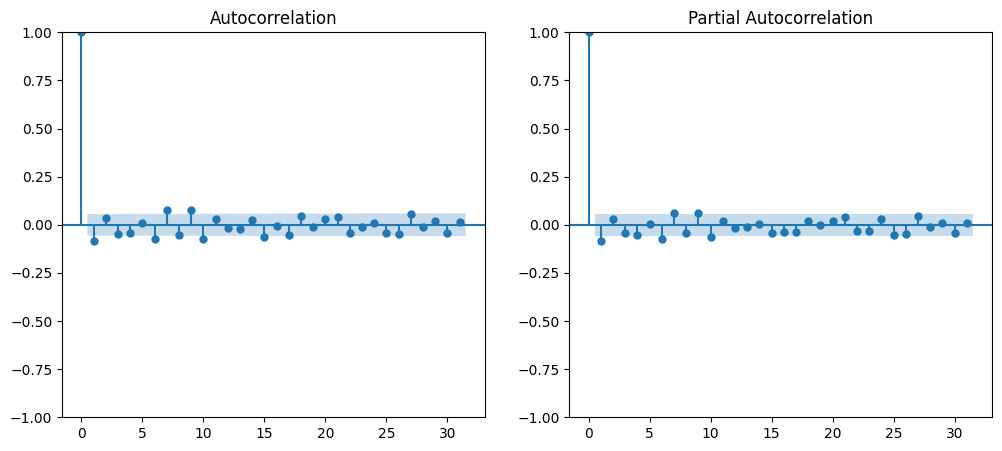

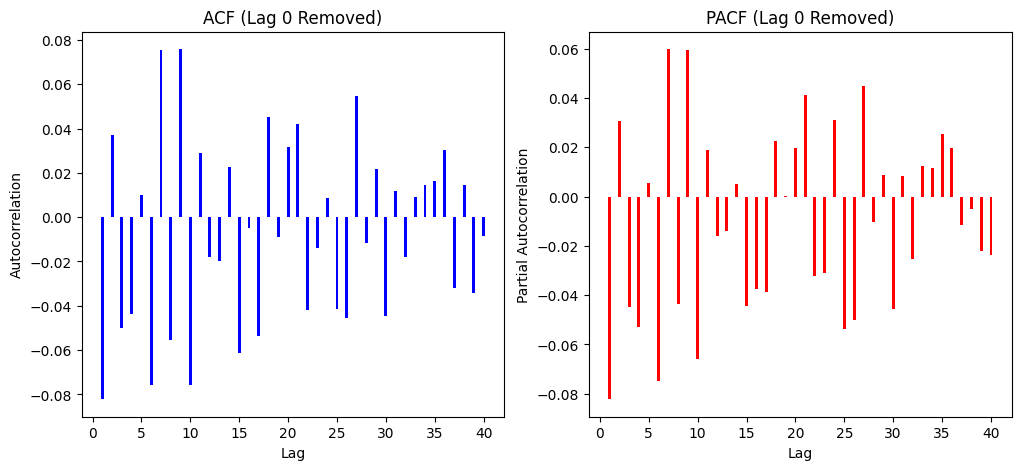

In [7]:
from statsmodels.tsa.stattools import acf, pacf

#Plot ACF and PACF to determine p and q
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(data_to_use, ax=axes[0]) 
plot_pacf(data_to_use, ax=axes[1]) 
plt.show()

#Compute ACF and PACF values (excluding lag 0)
acf_values = acf(data_to_use, nlags=40)[1:] 
pacf_values = pacf(data_to_use, nlags=40)[1:] 
lags = np.arange(1, 41)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF without lag 0
axes[0].bar(lags, acf_values, width=0.3, color='blue')
axes[0].set_title("ACF (Lag 0 Removed)")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Autocorrelation")

# Plot PACF without lag 0
axes[1].bar(lags, pacf_values, width=0.3, color='red')
axes[1].set_title("PACF (Lag 0 Removed)")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Partial Autocorrelation")

plt.show()


From the plots above we can see that correlation dies out over time, but even with lag 0 removed it is hard to make out exactly where the correlation dies out sufficiently to determine q and p. Therefore, we use the built-in function "auto_arima" which systematically tries out different parameter combinations and uses the Akaike Information Criterion (AIC) to select the best model. AIC balances goodness of fit with model complexity to prevent overfitting. The optimal ARIMA order is finally outputted at the end of the code below.

In [8]:
#Built-in function to determine paramters
auto_model = auto_arima(df['Close'], seasonal=False, stepwise=True, trace=True, suppress_warnings=True)
p, d, q = auto_model.order
print(f"Optimal ARIMA Order: ({p}, {d}, {q})")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13037.446, Time=3.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13070.446, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13064.094, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13064.574, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13072.218, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13066.329, Time=1.86 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13066.381, Time=1.65 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13064.685, Time=3.06 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13039.416, Time=3.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13064.524, Time=0.89 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13062.543, Time=2.84 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=13062.710, Time=3.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=13036.953, Time=4.69 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=13038.294, Time=5.20 sec
 ARIMA(3,1,4)(0,0,0

Now that the model parameters are determined as q = 3 and p = 3, we can fit the model to the dataset. A summary of the fitted model is outputted below.

In [9]:
#Fit model
model = ARIMA(df['Close'], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\isabe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\isabe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\isabe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1235
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -6514.806
Date:                Thu, 27 Mar 2025   AIC                          13043.611
Time:                        13:20:25   BIC                          13079.438
Sample:                             0   HQIC                         13057.088
                               - 1235                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8252     41.623     -0.020      0.984     -82.405      80.754
ar.L2          0.8524     75.191      0.011      0.991    -146.520     148.225
ar.L3          0.9029     38.301      0.024      0.9

From the outputted model above we can see that the autoregressive and moving average coefficients all have large standard errors that lead to high p-values. This suggests that the coefficients are not really statistically significant and therefore we could expect that the model will not perform very well in predicting future prices of the S&P 500 index which we will complete below. 

The test for constant variance with H = 0.79 suggests some heteroskedasticity, meaning that the variance of the residuals changes over time. This indicates that a GARCH model could be suitable to better capture volatility, which we will complete in section 3.3.

The code below loads the test dataset and uses the fitted ARIMA model to forecast future price levels. It also calulates the RMSE and MAE of the model. The forecast is plotted together with the actual price data, and the results will be further discussed under "Performance Evaluation" in section 4.1

C:\Users\isabe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\isabe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


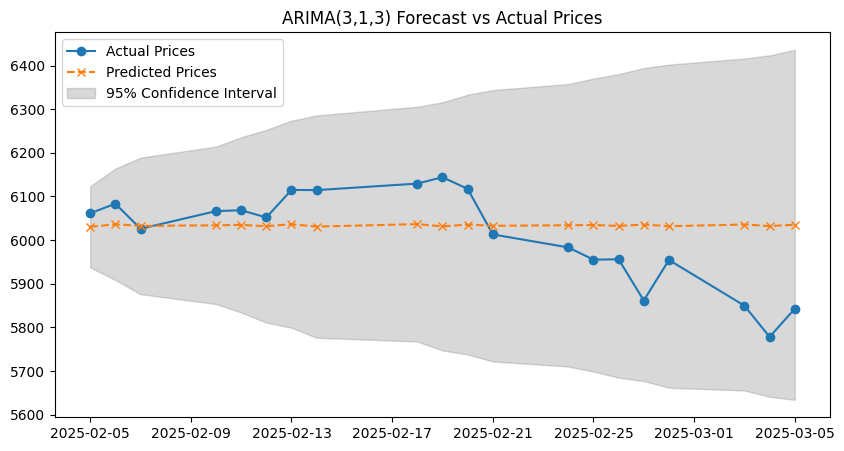

RMSE: 108.31728
MAE: 86.55794


In [13]:
#Load test dataset
test_df = pd.read_csv("test_data.csv")
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.set_index('Date', inplace=True)

#Forecast future price levels
forecast_obj = model_fit.get_forecast(steps=len(test_df))
forecast_mean = forecast_obj.predicted_mean
forecast_conf_int = forecast_obj.conf_int()

#Plot actual vs. predicted prices
plt.figure(figsize=(10, 5))
plt.plot(test_df.index, test_df['Close'], label="Actual Prices", marker='o')
plt.plot(test_df.index, forecast_mean, label="Predicted Prices", linestyle='dashed', marker='x')
plt.fill_between(test_df.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='gray', alpha=0.3, label="95% Confidence Interval")
plt.legend()
plt.title(f"ARIMA({p},{d},{q}) Forecast vs Actual Prices")
plt.show()

#Evaluate the model
rmse = np.sqrt(mean_squared_error(test_df['Close'], forecast_mean))
mae = mean_absolute_error(test_df['Close'], forecast_mean)
print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")

### 3.3 GARCH-model fitting and forecasting  
XXX Fyll inn

# 4. Performance Evaluation  

### 4.1 ARIMA-model  
The price levels predicted by the ARIMA model in section 3.2 are relatively flat compared to the actual prices which fluctuate. This may suggest the need for a more complex model. Also, the 95% confidence interval is quite wide, ranging almost 800 price points, which means that there is quite a bit of uncertainty in the predictions. A RMSE of 108.32 and MAE of 86.56 may seem high, but considering that the prices of the index are in the scale of 6000 these numbers indicate roughly a difference of 1.8% and 1.4% respectively to actual prices. 

### 4.2 GARCH-model  
XXX Fyll inn

# 5. Use of LLMs 

 XXX Fyll inn

# 6. Conclusion 

XXX Fyll inn 

# 7. References

- Boken 
- Legg til fler